This notebook provides a comprehensive analysis comparing attention mechanisms with SHAP values in transformer models. We demonstrate that attention weights, do not reliably indicate feature importance for model predictions.

We use 50 example sentences. Half positive, half negative covering simple, mixed feelings, sarcasm, negations, and even short or long cases. This gives us a diverse set of inputs to really test how attention vs. SHAP behave across lots of different ways people express sentiment.

In [40]:
test_sentences = [
    # straightforward positive
    "This movie was absolutely fantastic!",
    "Best purchase I've ever made!",

    # straightforward negative
    "I hate waiting in long lines.",
    "The service was terrible and disappointing.",

    # basic positive
    "I love how this product exceeded my expectations!",
    "The battery lasts all day and the screen looks gorgeous.",

    # basic negative
    "Absolutely horrible experience, would not recommend.",
    "The food was cold and the atmosphere was dull.",

    # mixed but net positive
    "The plot was great and the acting surprisingly strong.",
    "Great camera performance and smooth software!",

    # mixed but net negative
    "The battery life sucks and the software is glitchy.",
    "The sequel tried hard but bored me to tears.",

    # sarcastic positive
    "Wow, an upgrade that actually works—my faith in tech is restored!",
    "Oh look, the train arrived early; miracles do happen.",

    # sarcastic negative
    "Fantastic, my flight got delayed again!",
    "Oh great, another traffic jam—just what I needed!",

    # negation flavoured positive
    "I can't complain about this service; everything ran like clockwork.",
    "Not bad at all—actually kind of amazing!",

    # negation flavoured negative
    "I don't think I've ever been this underwhelmed by a sequel.",
    "It isn't exactly a triumph of design, to put it mildly.",

    # edge case positive
    "My day was made when the stranger paid for my coffee.",
    "Couldn't be happier with the customer support I received.",

    # edge case negative
    "If frustration were currency, I'd be rich after this update.",
    "Nothing like a broken promise to start the day badly.",

    # short ambiguous positive
    "Brilliant!",
    "Sweet success.",

    # short ambiguous negative
    "Meh.",
    "Utterly lame.",

    # long positive
    "The concert blew me away from start to finish.",

    # long negative
    "This conference was a snooze fest from keynote to close.",

    # basic positive
    "The vacation exceeded every expectation from start to finish.",
    "Customer support resolved my issue in minutes—absolute legends.",

    # basic negative
    "The hotel room smelled like mildew and disappointment.",
    "This update bricked my phone and erased all my photos.",

    # mixed net positive
    "The lecture was dense, yet the Q&A session was inspiring and insightful.",
    "Shipping took ages, but the packaging and quality were superb.",

    # mixed net negative
    "The dessert looked stunning, though it tasted like sweet cardboard.",
    "The interface feels modern, but it crashes whenever I click save.",

    # sarcastic positive
    "Wow, the app finally loaded without freezing; must be my lucky day!",
    "Amazing, my coffee order arrived exactly as requested—miracles happen.",

    # sarcastic negative
    "Lovely, the printer jammed again right before the deadline—fantastic timing.",
    "Great, another surprise fee on my bill—just what I needed today.",

    # negation flavoured positive
    "I can't say I'm unhappy with the results; they're actually impressive.",
    "It's hardly possible to be more satisfied than I am right now.",

    # negation flavoured negative
    "I wouldn't say the performance was unforgettable—in fact, I'd rather forget it.",
    "Not exactly the pinnacle of craftsmanship, is it?",

    # additional edge case positive
    "A stranger returned my lost wallet intact, restoring my faith in humanity.",
    "The sunrise painted the sky so beautifully it took my breath away.",

    # additional edge case negative
    "The constant drip from the ceiling turned my bedroom into a water park overnight.",
    "If boredom were lethal, that board meeting would have been a massacre."
]

## 1. Setup and Imports

Before running this notebook, make sure you have all the required packages installed. uncomment and run the cell below to install any missing libraries This notebook is designed for **Google Colab**.
- NOTE: If you're running itlocally, make sure you have Python and these packages installed.


In [41]:
# #uncomment to install required libraries
# !pip install -q transformers shap matplotlib seaborn pandas

In [42]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
from typing import List, Tuple, Dict, Any
import math

# transformers and SHAP
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import shap

warnings.filterwarnings('ignore')

# print(f"torch version:        {torch.__version__}")
# print(f"transformers version: {transformers.__version__}")
# print(f"shap version:         {shap.__version__}")]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Model Setup and Pipeline Initialization

Next, I choose a pretrained sentiment model (DistilBERT fine-tuned on SST-2) and load it so I can get both positive and negative scores for any sentence. I used the raw model and tokenizer objects because I’ll need them to check at the attention layers. Finally, I make the whole pipeline in SHAP’s TransformersPipeline with a text masker so I can explain which words really drive the prediction.

In [43]:
# sentiment analysis pipeline
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline(
    "sentiment-analysis",
    model=model_name,
    return_all_scores=True,
    device=device)

# extract the model and tokenizer
model = classifier.model
tokenizer = classifier.tokenizer

# SHAP explainer
shap_model = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
explainer = shap.Explainer(shap_model, shap.maskers.Text(tokenizer))

model.to(device)

Device set to use cpu


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## 3. Analysis Functions

I define three helpers:  
- `extract_attention_weights` get the last layer’s CLS to token attention scores,  
- `extract_shap_values` runs SHAP and pulls out each word’s importance,  
- `analyze_text` bind it all together by predicting sentiment, normalizing attention, calling both extractors, and returning one result.

In [44]:
def extract_attention_weights(text: str, max_length: int = 128) -> Tuple[List[str], np.ndarray]:
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length)

    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    # attentions, tuple of (batch, heads, seq, seq)
    last_attn = outputs.attentions[-1]
    avg_heads = last_attn.mean(dim=1)
    cls_to_tokens = avg_heads[0, 0].cpu().numpy()

    return tokens, cls_to_tokens

def extract_shap_values(text: str, max_evals: int = 100) -> Tuple[List[str], np.ndarray, float]:
    sv = explainer([text], max_evals=max_evals)
    tokens = sv.data[0]
    values = sv.values[0][:, 1]
    base_value = float(sv.base_values[0][1])
    return tokens, values, base_value

def analyze_text(text: str) -> Dict[str, Any]:
    # prediction scores
    result = classifier(text)[0]
    pos_score = next(x["score"] for x in result if x["label"].upper().startswith("POS"))
    neg_score = next(x["score"] for x in result if x["label"].upper().startswith("NEG"))
    sentiment = "positive" if pos_score > neg_score else "negative"
    confidence = max(pos_score, neg_score)

    # attention and SHAP
    att_tokens, att_scores = extract_attention_weights(text)
    att_norm = (att_scores - att_scores.min()) / (att_scores.max() - att_scores.min() + 1e-8)
    shap_tokens, shap_scores, base_val = extract_shap_values(text)

    return {
        "text": text,
        "sentiment": sentiment,
        "confidence": confidence,
        "pos_score": pos_score,
        "neg_score": neg_score,
        "attention": {"tokens": att_tokens, "scores": att_norm},
        "shap": {"tokens": shap_tokens, "scores": shap_scores, "base_value": base_val}}

## 4. Test Sentences for Analysis

We loop through each sentence and run my `analyze_text` function to get attention maps, SHAP values, and sentiment.

In [45]:
# analyze all sentences
results = []
for sentence in test_sentences:
    print(f"Analyzing: {sentence}")
    analysis = analyze_text(sentence)
    results.append(analysis)

Analyzing: This movie was absolutely fantastic!
Analyzing: Best purchase I've ever made!
Analyzing: I hate waiting in long lines.
Analyzing: The service was terrible and disappointing.
Analyzing: I love how this product exceeded my expectations!
Analyzing: The battery lasts all day and the screen looks gorgeous.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Absolutely horrible experience, would not recommend.
Analyzing: The food was cold and the atmosphere was dull.
Analyzing: The plot was great and the acting surprisingly strong.
Analyzing: Great camera performance and smooth software!
Analyzing: The battery life sucks and the software is glitchy.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: The sequel tried hard but bored me to tears.
Analyzing: Wow, an upgrade that actually works—my faith in tech is restored!
Analyzing: Oh look, the train arrived early; miracles do happen.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Fantastic, my flight got delayed again!
Analyzing: Oh great, another traffic jam—just what I needed!


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: I can't complain about this service; everything ran like clockwork.
Analyzing: Not bad at all—actually kind of amazing!
Analyzing: I don't think I've ever been this underwhelmed by a sequel.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: It isn't exactly a triumph of design, to put it mildly.
Analyzing: My day was made when the stranger paid for my coffee.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Couldn't be happier with the customer support I received.
Analyzing: If frustration were currency, I'd be rich after this update.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Nothing like a broken promise to start the day badly.
Analyzing: Brilliant!
Analyzing: Sweet success.
Analyzing: Meh.
Analyzing: Utterly lame.
Analyzing: The concert blew me away from start to finish.
Analyzing: This conference was a snooze fest from keynote to close.
Analyzing: The vacation exceeded every expectation from start to finish.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Customer support resolved my issue in minutes—absolute legends.
Analyzing: The hotel room smelled like mildew and disappointment.
Analyzing: This update bricked my phone and erased all my photos.
Analyzing: The lecture was dense, yet the Q&A session was inspiring and insightful.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Shipping took ages, but the packaging and quality were superb.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: The dessert looked stunning, though it tasted like sweet cardboard.
Analyzing: The interface feels modern, but it crashes whenever I click save.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Wow, the app finally loaded without freezing; must be my lucky day!
Analyzing: Amazing, my coffee order arrived exactly as requested—miracles happen.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Lovely, the printer jammed again right before the deadline—fantastic timing.
Analyzing: Great, another surprise fee on my bill—just what I needed today.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: I can't say I'm unhappy with the results; they're actually impressive.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: It's hardly possible to be more satisfied than I am right now.
Analyzing: I wouldn't say the performance was unforgettable—in fact, I'd rather forget it.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: Not exactly the pinnacle of craftsmanship, is it?
Analyzing: A stranger returned my lost wallet intact, restoring my faith in humanity.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: The sunrise painted the sky so beautifully it took my breath away.
Analyzing: The constant drip from the ceiling turned my bedroom into a water park overnight.


  0%|          | 0/98 [00:00<?, ?it/s]

Analyzing: If boredom were lethal, that board meeting would have been a massacre.


In [46]:
# results[0]

## 5. Side-by-Side Token Importance Visualization

- On the left we see where the model looked (normalized attention)
- On the right we see what really drove its decision (|SHAP values|)
- Showing positive or negative impact. This makes it easy to compare word by word how attention and real importance align.  

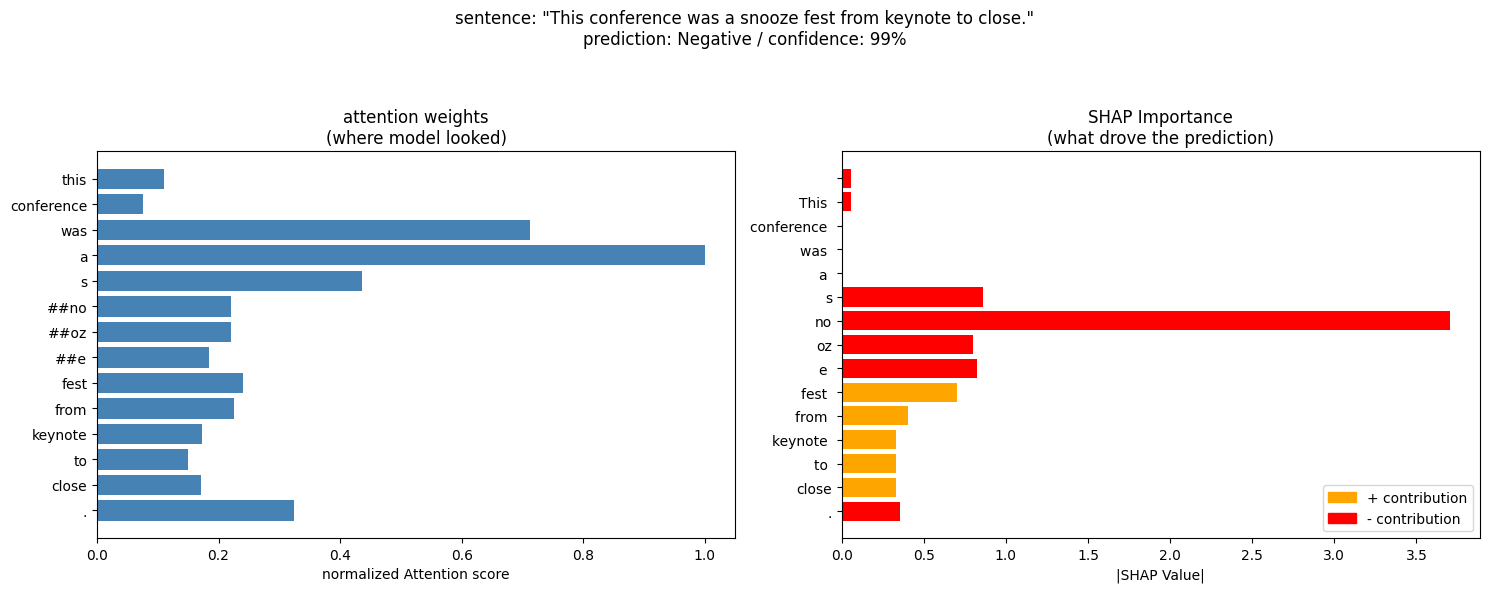

In [47]:
def plot_token_importance_comparison(result: dict, figsize=(15, 6)):
    # barchart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # atttention subplot
    att_tokens = result['attention']['tokens']
    att_scores = result['attention']['scores']

    # filter out special/pad tokens
    filtered = [(t, s) for t, s in zip(att_tokens, att_scores) if t not in ('[CLS]', '[SEP]', '[PAD]')]
    tokens_att, scores_att = zip(*filtered)

    ax1.barh(tokens_att, scores_att, color='steelblue')
    ax1.set_xlabel('normalized Attention score')
    ax1.set_title('attention weights\n(where model looked)')
    ax1.invert_yaxis()

    # SHAP subplot
    shap_tokens = result['shap']['tokens']
    shap_scores = result['shap']['scores']
    colors = ['orange' if v >= 0 else 'red' for v in shap_scores]

    ax2.barh(shap_tokens, np.abs(shap_scores), color=colors)
    ax2.set_xlabel('|SHAP Value|')
    ax2.set_title('SHAP Importance\n(what drove the prediction)')
    ax2.invert_yaxis()

    # legend for SHAP
    orange_patch = mpatches.Patch(color='orange', label='+ contribution')
    red_patch = mpatches.Patch(color='red', label='- contribution')
    ax2.legend(handles=[orange_patch, red_patch], loc='lower right')

    # title
    fig.suptitle(
        f'sentence: "{result["text"]}"\n'
        f'prediction: {result["sentiment"].capitalize()} / '
        f'confidence: {result["confidence"]:.0%}')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    return fig

# checking a sentences
for res in results[29:30:]:
    fig = plot_token_importance_comparison(res)
    plt.show()

## 6. Correlation Analysis Across All Samples

- Check how attention and SHAP line up across all sentences. We compute a Pearson r for each pair of token scores.

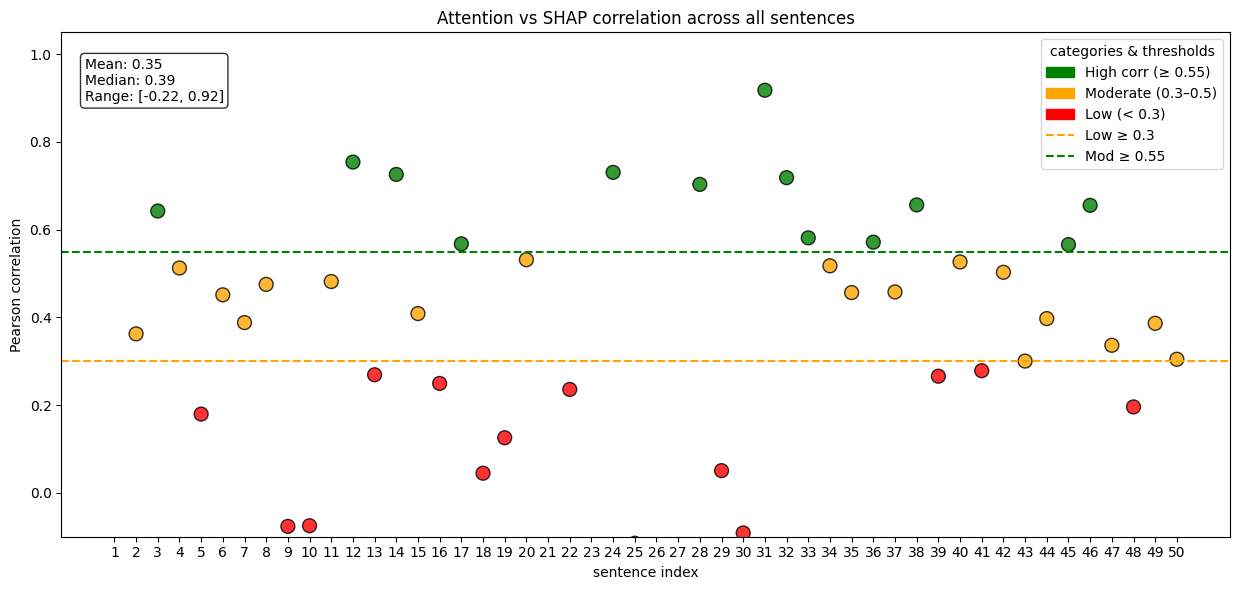

In [48]:
# data
correlations = []
for result in results:
    att = np.array(result['attention']['scores'])
    shap_vals = np.abs(result['shap']['scores'])
    n = min(len(att), len(shap_vals))
    correlations.append(np.corrcoef(att[:n], shap_vals[:n])[0, 1])

# thresholds & categories
low_thr, mod_thr = 0.3, 0.55
categories = []
for c in correlations:
    if c < low_thr:
        categories.append('low')
    elif c < mod_thr:
        categories.append('moderate')
    else:
        categories.append('high')

color_map = {'low': 'red', 'moderate': 'orange', 'high': 'green'}
colors = [color_map[cat] for cat in categories]

# figure sizing
n = len(correlations)
width = max(12, n * 0.25)
fig, ax = plt.subplots(figsize=(width, 6))

# scatter plot of correlations
indices = np.arange(1, n+1)
ax.scatter(indices, correlations, c=colors, s=100, edgecolor='k', alpha=0.8)

# threshold lines
ax.axhline(low_thr, color='orange', linestyle='--', linewidth=1.5, label=f'Low ≥ {low_thr}')
ax.axhline(mod_thr, color='green', linestyle='--', linewidth=1.5, label=f'Mod ≥ {mod_thr}')

# labels & ticks
ax.set_xlabel("sentence index")
ax.set_ylabel("Pearson correlation")
ax.set_title("Attention vs SHAP correlation across all sentences")
ax.set_xticks(indices)
ax.set_ylim(-0.1, 1.05)

# legend
legend_handles = [
    Patch(color='green', label='High corr (≥ 0.55)'),
    Patch(color='orange', label='Moderate (0.3–0.5)'),
    Patch(color='red', label='Low (< 0.3)')
]
line_handles = [ax.lines[0], ax.lines[1]]  # threshold lines
ax.legend(handles=legend_handles + line_handles, loc='upper right', title="categories & thresholds")

# summary biox
mean_corr = np.mean(correlations)
median_corr = np.median(correlations)
stats_txt = f"Mean: {mean_corr:.2f}\nMedian: {median_corr:.2f}\nRange: [{min(correlations):.2f}, {max(correlations):.2f}]"
ax.text(0.02, 0.95, stats_txt, transform=ax.transAxes,verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

- Attention scores alone are a poor proxy for real feature importance. While a some of sentences show decent alignment (green)
- but as we can see
- The red dots remind us that “where the model looks” is only part of the picture, and SHAP reveals a different side of its reasoning.

## 7. Token-Level Disagreement Analysis

Here I made a small helper to spotlight the words where attention and SHAP really disagree. First, `analyze_disagreements` trims out special tokens, lines up attention vs. SHAP scores, and ranks by their absolute difference. Then `plot_all_disagreements` lays out the top few tokens for each sentence in a neat grid so you can spot which words pull attention one way but SHAP another.  

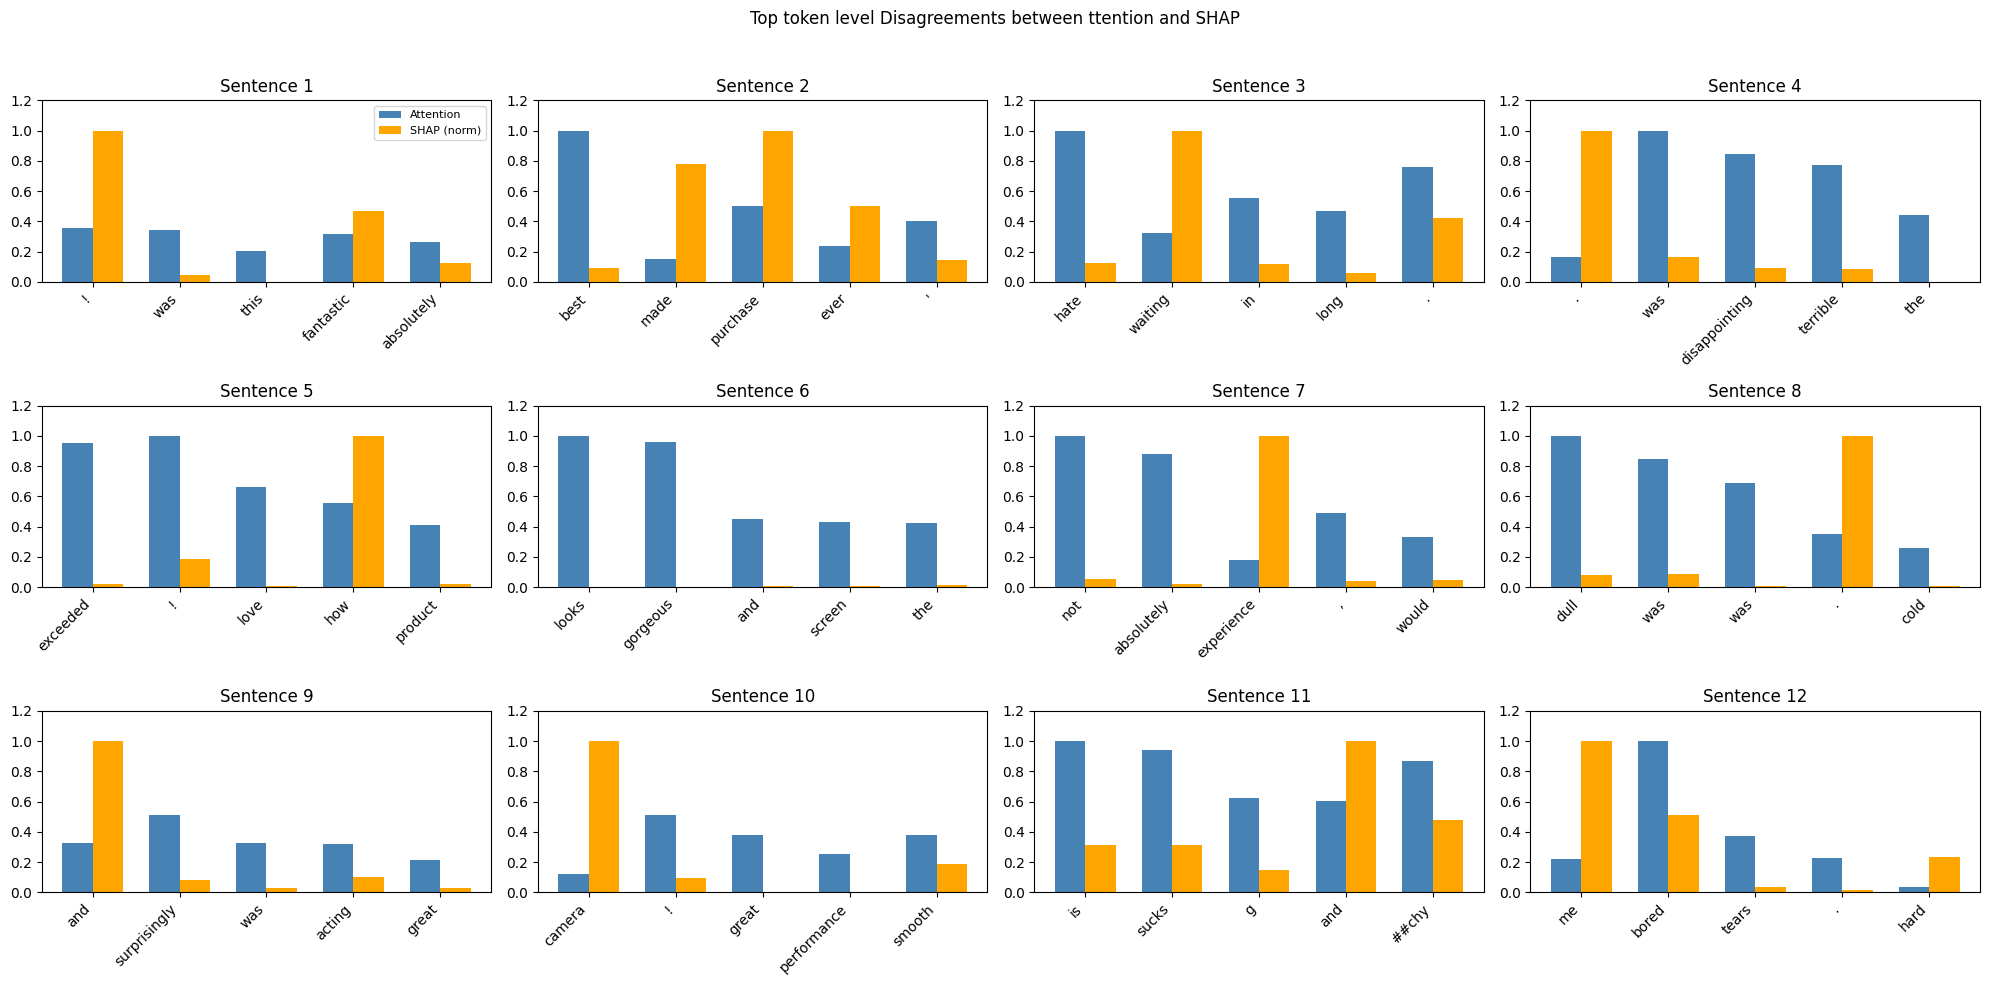

In [49]:
def analyze_disagreements(result):
    # identify tokens where attention and SHAP disagree most
    att_tokens = result['attention']['tokens']
    att_scores = np.array(result['attention']['scores'])
    shap_scores = np.abs(result['shap']['scores'])

    # trim attention to real tokens (between [CLS] and [SEP])
    if '[CLS]' in att_tokens and '[SEP]' in att_tokens:
        start = att_tokens.index('[CLS]') + 1
        end = att_tokens.index('[SEP]')
        real_tokens = att_tokens[start:end]
        real_att = att_scores[start:end]
    else:
        # fallback, drop any special tokens
        special = {'[CLS]', '[SEP]', '[PAD]'}
        real = [(t, s) for t, s in zip(att_tokens, att_scores) if t not in special]
        real_tokens, real_att = zip(*real)
        real_att = np.array(real_att)

    # align lengths
    n = min(len(real_tokens), len(shap_scores))
    df = pd.DataFrame({
        'token': real_tokens[:n],
        'attention': real_att[:n],
        'shap_norm': shap_scores[:n] / (shap_scores.max() + 1e-8)})

    df['disagreement'] = np.abs(df['attention'] - df['shap_norm'])
    return df.sort_values('disagreement', ascending=False)

def plot_all_disagreements(results, top_k=5, cols=4, figsize=(20, 10)):
    # plot the top_k token-level disagreements for each result in a grid.

    n = len(results)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    axes_flat = axes.flatten()

    for idx, result in enumerate(results):
        ax = axes_flat[idx]
        df = analyze_disagreements(result).head(top_k)
        x = np.arange(len(df))
        width = 0.35

        ax.bar(x - width/2, df['attention'], width, label='Attention', color='steelblue')
        ax.bar(x + width/2, df['shap_norm'], width, label='SHAP (norm)', color='orange')

        ax.set_xticks(x)
        ax.set_xticklabels(df['token'], rotation=45, ha='right')
        ax.set_ylim(0, 1.2)
        ax.set_title(f"Sentence {idx+1}")

        # legend on first subplot
        if idx == 0:
            ax.legend(fontsize=8)

    # turn off any unused axes
    for j in range(idx+1, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.suptitle('Top token level Disagreements between ttention and SHAP')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# plot top 5 disagreements for first 8 sentence
plot_all_disagreements(results[:12:], top_k=5, cols=4)

**This plot makes clear that attention and SHAP often spotlight different tokens**

## 8. Attention vs. SHAP Scatter Plot

- I append every word’s normalized attention and SHAP scores across all sentences and plot them.
- The dot color shows how much the model attended to each token.

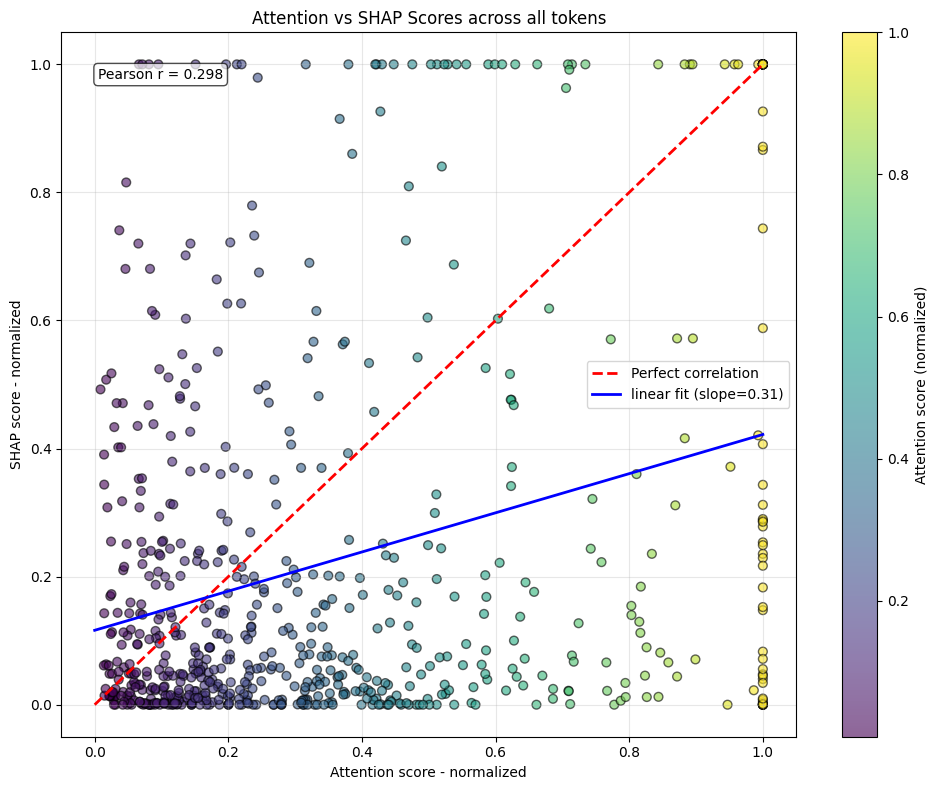

In [50]:
all_attention = []
all_shap = []

for res in results:
    att = np.array(res['attention']['scores'])
    shap_vals = np.abs(res['shap']['scores'])
    # normalize SHAP per sentence
    shap_norm = shap_vals / (shap_vals.max() + 1e-8)
    # align lengths
    n = min(len(att), len(shap_norm))
    all_attention.extend(att[:n])
    all_shap.extend(shap_norm[:n])

# convert to arrays
all_attention = np.array(all_attention)
all_shap = np.array(all_shap)

# plot
fig, ax = plt.subplots(figsize=(10, 8))

# scatter colored by attention score
sc = ax.scatter(
    all_attention,
    all_shap,
    c=all_attention,
    cmap='viridis',
    s=40,
    edgecolor='k',
    alpha=0.6
)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Attention score (normalized)')

# perfect correlation diagonal
ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect correlation')

# linear fit
coef = np.polyfit(all_attention, all_shap, 1)
poly = np.poly1d(coef)
ax.plot([0, 1], poly([0, 1]), 'b-', lw=2, label=f'linear fit (slope={coef[0]:.2f})')

# labels, title, grid, legend
ax.set_xlabel('Attention score - normalized')
ax.set_ylabel('SHAP score - normalized')
ax.set_title('Attention vs SHAP Scores across all tokens')
ax.legend()
ax.grid(alpha=0.3)

# overall correlation annotation
overall_corr = np.corrcoef(all_attention, all_shap)[0, 1]
ax.text(
    0.05, 0.95,
    f'Pearson r = {overall_corr:.3f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

In this scatter plot, every dot is one token from across all our sentences.
- normalized attention score on the x-axis
- normalized |SHAP| importance on the y-axis

The color of each point (from purple to yellow) tells you how strongly the model actually looked at that word, while its vertical position shows how much that word truly impacted the prediction.

Interestingly we can see how **most tokens lie near the bottom** even when the model pays a lot of attention (the yellow dots on the far right), the SHAP values often stay low. That tells us attention alone can be very misleading: just because a word lights up the attention map doesn’t mean it really mattered for the final sentiment.

## 9. Heatmap Visualization

Now I turn every sentence’s attention and SHAP scores into heatmaps side by side. Each row is one sentence.
- Blues show where the model paid attention, Oranges show each word’s SHAP importance (normalized per sentence), and the red-blue map highlights their difference.

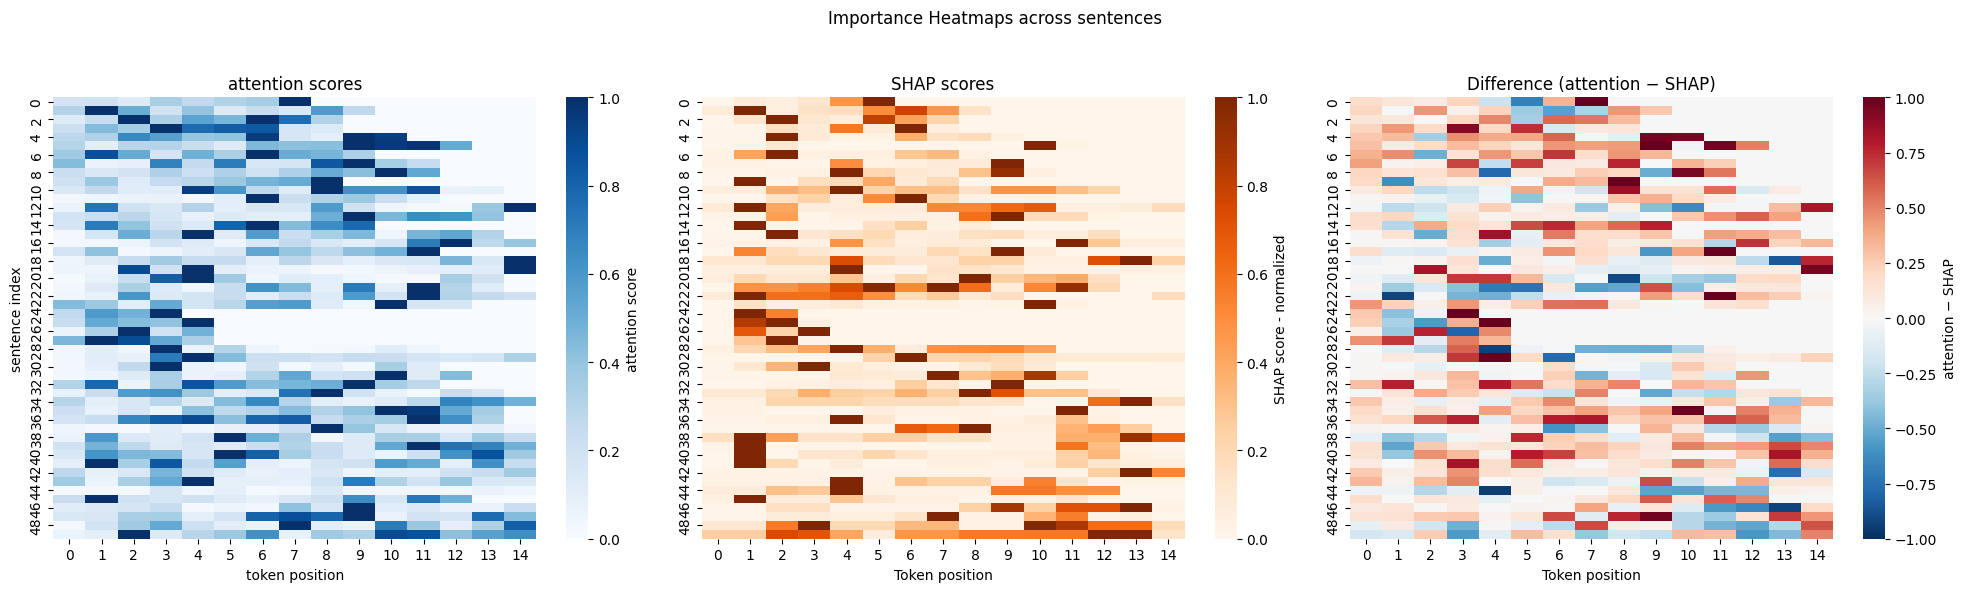

In [51]:
def create_importance_heatmap(results, max_tokens=15):
    # heatmaps of attention and SHAP and their difference

    n_samples = len(results)
    # pre allocate matrices
    att_matrix = np.zeros((n_samples, max_tokens))
    shap_matrix = np.zeros((n_samples, max_tokens))

    for i, res in enumerate(results):
        # grab and truncate
        att = np.array(res['attention']['scores'])[:max_tokens]
        shp = np.abs(np.array(res['shap']['scores']))[:max_tokens]
        # fill into rows
        att_matrix[i, :att.shape[0]] = att
        shap_matrix[i, :shp.shape[0]] = shp

    # normalize SHAP per row to [0,1]
    row_max = shap_matrix.max(axis=1, keepdims=True) + 1e-8
    shap_norm = shap_matrix / row_max

    # difference
    diff = att_matrix - shap_norm

    # plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    sns.heatmap(
        att_matrix,
        ax=ax1,
        cmap='Blues',
        vmin=0,
        vmax=1,
        cbar_kws={'label':'attention score'})

    ax1.set_title('attention scores')
    ax1.set_xlabel('token position')
    ax1.set_ylabel('sentence index')

    sns.heatmap(
        shap_norm,
        ax=ax2,
        cmap='Oranges',
        vmin=0,
        vmax=1,
        cbar_kws={'label':'SHAP score - normalized'})

    ax2.set_title('SHAP scores')
    ax2.set_xlabel('Token position')
    ax2.set_ylabel('')

    # symmetric color scale around zero for difference
    max_abs = np.max(np.abs(diff))
    sns.heatmap(
        diff,
        ax=ax3,
        cmap='RdBu_r',
        center=0,
        vmin=-max_abs,
        vmax=max_abs,
        cbar_kws={'label':'attention − SHAP'})

    ax3.set_title('Difference (attention − SHAP)')
    ax3.set_xlabel('Token position')
    ax3.set_ylabel('')

    plt.suptitle('Importance Heatmaps across sentences')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

fig = create_importance_heatmap(results, max_tokens=15)
plt.show()

In this heatmaps, each row is one test sentence (I’ve limited to 15 tokens per row, padding or cutting longer ones).

This side-by-side comparison makes it clear that attention alone isn’t a reliable explanation—SHAP reveals an entirely different layer of what truly influences the model’s predictions.

## 10 Results
Finally, I print a summary of samples analyzed, average correlation, range, and low-agreement rate.

In [52]:
# summary calculations
mean_correlation = np.mean(correlations)
low_thr = 0.3
low_corr_count = sum(c < low_thr for c in correlations)

# summary
print(f"samples analyzed:       {len(results)}")
print(f"average correlation:    {mean_correlation:.3f}")
print(f"correlation range:      [{min(correlations):.3f}, {max(correlations):.3f}]")
print(f"low correlation samples (< {low_thr}): {low_corr_count}/{len(correlations)} "
      f"({low_corr_count/len(correlations)*100:.1f}%)")

samples analyzed:       50
average correlation:    0.346
correlation range:      [-0.217, 0.918]
low correlation samples (< 0.3): 19/50 (38.0%)


### **Attention and SHAP capture different aspects of model behavior.**
